## Data Preprocessing & Sanity Checks (YOLO Detection)

# This notebook performs lightweight preprocessing and verification for a YOLO-format traffic sign dataset.

# It will:

# - Automatically locate the project root and dataset folder
# - Verify split folders (`train`, `valid`, `test`) and image/label pairing  
# - Use a fixed list of class names (from `data.yaml`)
# - Check label files for common issues (missing files, empty files, invalid values)  
# - Visualize a few samples with bounding boxes drawn on them  
# - Summarize dataset counts

In [ ]:
from pathlib import Path
import os, re

# Detect whether this is a .py script or a notebook
if "__file__" in globals():
    # Running from a Python script
    PROJECT_ROOT = Path(__file__).resolve().parents[2]
else:
    # Running inside a Jupyter notebook
    PROJECT_ROOT = Path.cwd().resolve()
    # Climb up the directory tree until it finds a folder that has archive/car
    for parent in [PROJECT_ROOT] + list(PROJECT_ROOT.parents):
        if (parent / "archive" / "car").exists():
            PROJECT_ROOT = parent
            break

print("Detected project root:", PROJECT_ROOT)

# Dataset folder relative to the project root
DATASET_ROOT = PROJECT_ROOT / "archive" / "car"
print("Dataset root:", DATASET_ROOT)

# Sanity check
if not DATASET_ROOT.exists():
    raise FileNotFoundError(
        f"Dataset folder not found at: {DATASET_ROOT}\n"
        "Make sure your repo contains /archive/car with train/valid/test."
    )

# Class names from your data.yaml
CLASS_NAMES = [
    'Green Light', 'Red Light', 'Speed Limit 10', 'Speed Limit 100',
    'Speed Limit 110', 'Speed Limit 120', 'Speed Limit 20', 'Speed Limit 30',
    'Speed Limit 40', 'Speed Limit 50', 'Speed Limit 60', 'Speed Limit 70',
    'Speed Limit 80', 'Speed Limit 90', 'Stop'
]

SPLITS = ['train', 'valid', 'test']
SAMPLES_PER_SPLIT = 3  # how many example images to preview per split

print("Class names:", CLASS_NAMES)


Detected project root: C:\Users\devem\Documents\GitHub\CSCI-331-04-Group-2
Dataset root: C:\Users\devem\Documents\GitHub\CSCI-331-04-Group-2\archive\car
Class names: ['Green Light', 'Red Light', 'Speed Limit 10', 'Speed Limit 100', 'Speed Limit 110', 'Speed Limit 120', 'Speed Limit 20', 'Speed Limit 30', 'Speed Limit 40', 'Speed Limit 50', 'Speed Limit 60', 'Speed Limit 70', 'Speed Limit 80', 'Speed Limit 90', 'Stop']


In [2]:
from collections import defaultdict
from PIL import Image, ImageDraw
from itertools import islice
import matplotlib.pyplot as plt
from pathlib import Path


## Step 1: Check image/label counts per split

In [ ]:
def count_images_labels(root: Path):
    # List to store statistics for each dataset split (train/val/test)
    stats = []

    # Loop through each split defined in SPLITS
    for split in SPLITS:
        # Paths to the images/ and labels/ directories inside this split
        img_dir = root / split / "images"
        lbl_dir = root / split / "labels"

        # Collect all image files (jpg, jpeg, png, bmp, webp)
        imgs = sorted([
            p for p in img_dir.glob("*")
            if p.suffix.lower() in {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
        ])

        # Collect all label files (.txt)
        labels = sorted(list(lbl_dir.glob("*.txt")))

        # Get just the filenames WITHOUT extensions (stems)
        img_basenames = {p.stem for p in imgs}
        lbl_basenames = {p.stem for p in labels}

        # Find images that are missing label files
        missing_lbl = sorted(list(img_basenames - lbl_basenames))

        # Find labels that are missing corresponding images
        missing_img = sorted(list(lbl_basenames - img_basenames))

        # Store statistics for this split
        stats.append({
            "split": split,
            "num_images": len(imgs),
            "num_labels": len(labels),
            "missing_labels_for_images": len(missing_lbl),
            "missing_images_for_labels": len(missing_img),
        })

        # Print a quick summary for debugging/verification
        print(
            f"[{split}] images={len(imgs)} labels={len(labels)} "
            f"missing_labels={len(missing_lbl)} missing_images={len(missing_img)}"
        )

    return stats


stats = count_images_labels(DATASET_ROOT)
stats


[train] images=3530 labels=3530 missing_labels=0 missing_images=0
[valid] images=801 labels=801 missing_labels=0 missing_images=0
[test] images=638 labels=638 missing_labels=0 missing_images=0


[{'split': 'train',
  'num_images': 3530,
  'num_labels': 3530,
  'missing_labels_for_images': 0,
  'missing_images_for_labels': 0},
 {'split': 'valid',
  'num_images': 801,
  'num_labels': 801,
  'missing_labels_for_images': 0,
  'missing_images_for_labels': 0},
 {'split': 'test',
  'num_images': 638,
  'num_labels': 638,
  'missing_labels_for_images': 0,
  'missing_images_for_labels': 0}]

## Step 2: Validate YOLO label file format and values


In [ ]:
def check_label_file(txt_path: Path, num_classes: int | None):
    issues = []

    # If the file doesn’t exist → record “missing”
    if not txt_path.exists():
        issues.append("missing")
        return issues

    # Read file content (all lines)
    content = txt_path.read_text().strip().splitlines()

    # Empty file → no labels inside
    if not content:
        issues.append("empty")
        return issues

    # Loop through each line in the label file
    for i, line in enumerate(content, 1):
        parts = line.strip().split()

        # A correct YOLO label line contains 5 values:
        # class_id, x_center, y_center, width, height
        if len(parts) != 5:
            issues.append(f"line {i}: expected 5 values, got {len(parts)} -> {line!r}")
            continue

        # Try converting these values to numbers
        try:
            cls = int(float(parts[0]))      # class id
            xc, yc, w, h = map(float, parts[1:])  # box coordinates
        except Exception as e:
            issues.append(f"line {i}: parse error -> {e}")
            continue

        # Check if class ID is within expected range
        if num_classes is not None and (cls < 0 or cls >= num_classes):
            issues.append(f"line {i}: class id {cls} out of range [0,{num_classes-1}]")

        # Validate all numeric values (must be between 0 and 1 — YOLO format)
        for name, v in (("xc", xc), ("yc", yc), ("w", w), ("h", h)):
            if not (0.0 <= v <= 1.0):
                issues.append(f"line {i}: {name}={v} outside [0,1]")

        # w and h must be positive — bounding box can't be flat
        if w <= 0 or h <= 0:
            issues.append(f"line {i}: non-positive box size w={w}, h={h}")

    return issues


def scan_labels(root: Path, num_classes: int | None, limit_per_split: int = 50):
    report = []

    # Go through train / valid / test splits
    for split in SPLITS:
        lbl_dir = root / split / "labels"

        # Get up to N label files from this split
        txts = sorted(list(lbl_dir.glob("*.txt")))[:limit_per_split]

        # Check every label file
        for t in txts:
            issues = check_label_file(t, num_classes)

            # If problems exist, add to detailed report
            if issues:
                report.append((t, issues))

    return report


num_classes = len(CLASS_NAMES) if CLASS_NAMES is not None else None

issues = scan_labels(DATASET_ROOT, num_classes=num_classes, limit_per_split=200)

print(f"Found {len(issues)} files with issues (scanned up to 200 per split).")
issues[:10]  # show first 10 problems



Found 0 files with issues (scanned up to 200 per split).


[]

## Step 3: Visualize a few samples with bounding boxes


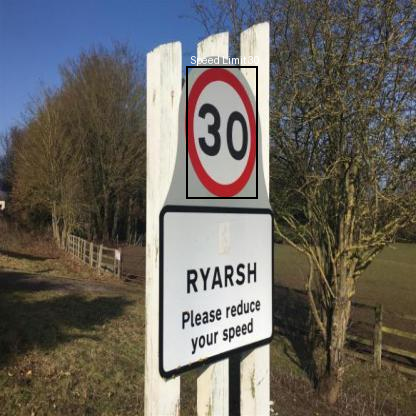

Saved preview: C:\Users\devem\Documents\GitHub\CSCI-331-04-Group-2\archive\car\_previews\train__000000_jpg.rf.b11f308f16626f9f795a148029c46d10.jpg


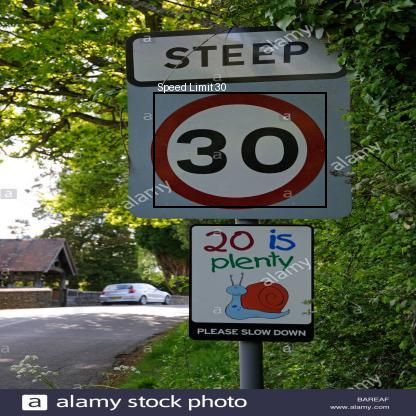

Saved preview: C:\Users\devem\Documents\GitHub\CSCI-331-04-Group-2\archive\car\_previews\train__000005_jpg.rf.d730849ae93a7c211a7c8f57ed851028.jpg


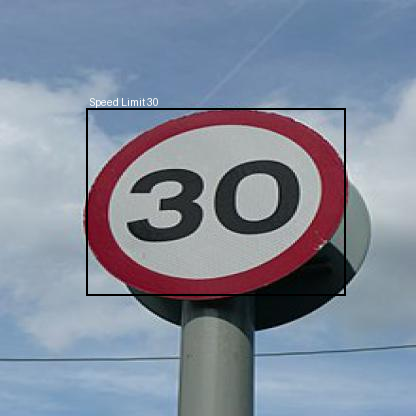

Saved preview: C:\Users\devem\Documents\GitHub\CSCI-331-04-Group-2\archive\car\_previews\train__000007_jpg.rf.226fe0751cf8ba445b8f87970e70f606.jpg


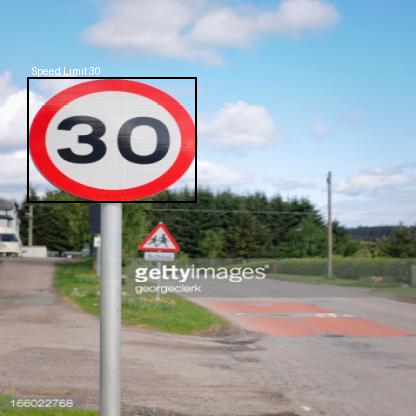

Saved preview: C:\Users\devem\Documents\GitHub\CSCI-331-04-Group-2\archive\car\_previews\valid__000001_jpg.rf.5eb4f984823b1a44afc9bf98804daa50.jpg


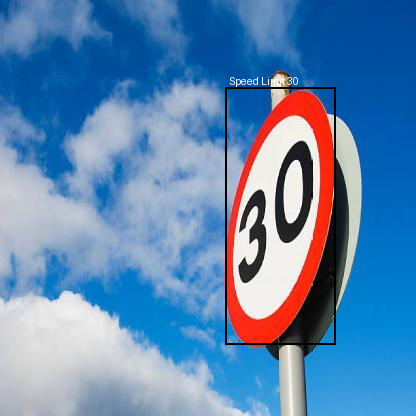

Saved preview: C:\Users\devem\Documents\GitHub\CSCI-331-04-Group-2\archive\car\_previews\valid__000002_jpg.rf.d65ebeef4d1cb26e3fc1a826770b729f.jpg


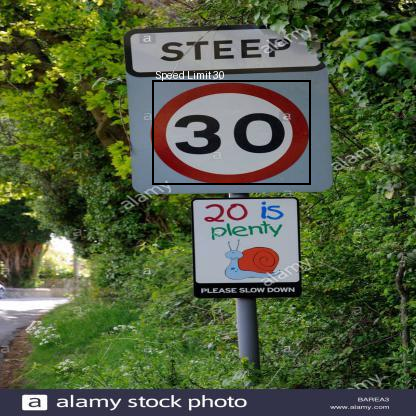

Saved preview: C:\Users\devem\Documents\GitHub\CSCI-331-04-Group-2\archive\car\_previews\valid__000004_jpg.rf.00126fe7725236ec5dc849bac78543c2.jpg


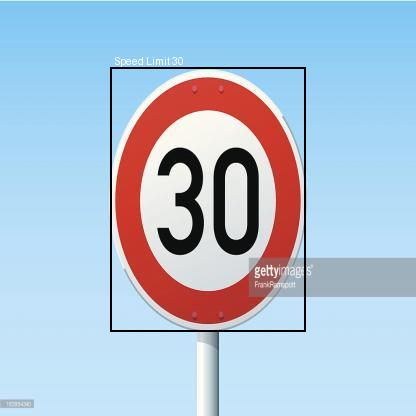

Saved preview: C:\Users\devem\Documents\GitHub\CSCI-331-04-Group-2\archive\car\_previews\test__000003_jpg.rf.8511b9c219dbf9799a6d58900b15917d.jpg


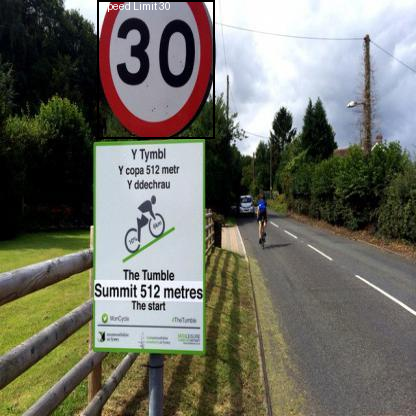

Saved preview: C:\Users\devem\Documents\GitHub\CSCI-331-04-Group-2\archive\car\_previews\test__000006_jpg.rf.89610ec419ccfab22f8314026b90ee26.jpg


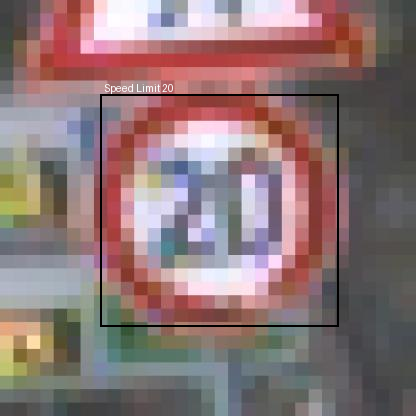

Saved preview: C:\Users\devem\Documents\GitHub\CSCI-331-04-Group-2\archive\car\_previews\test__00000_00000_00003_png.rf.d18afc3c9625ffb1974029d3e3762aee.jpg


In [ ]:
# Create a directory to store preview images with bounding boxes
preview_dir = DATASET_ROOT / "_previews"
preview_dir.mkdir(exist_ok=True)


def draw_boxes(image_path: Path, label_path: Path, class_names=None, max_labels=100):
    """
    Draw bounding boxes on an image using its YOLO label file.
    Returns the annotated PIL image.
    """

    # Load image as RGB
    im = Image.open(image_path).convert("RGB")
    W, H = im.size  # image width and height

    draw = ImageDraw.Draw(im)  # object for drawing boxes & text

    # If no label file exists, return plain image
    if not label_path.exists():
        return im

    # Read all label lines from file
    lines = label_path.read_text().strip().splitlines()

    # Loop through each YOLO label (limit for safety)
    for i, line in enumerate(islice(lines, max_labels)):
        parts = line.strip().split()

        # Labels MUST have 5 items: class_id, x_center, y_center, width, height
        if len(parts) != 5:
            continue

        # Parse the YOLO label values
        cls = int(float(parts[0]))
        xc, yc, w, h = map(float, parts[1:])

        # Convert normalized YOLO coords → pixel coordinates
        x1 = (xc - w/2) * W
        y1 = (yc - h/2) * H
        x2 = (xc + w/2) * W
        y2 = (yc + h/2) * H

        # Draw bounding box on image
        draw.rectangle([x1, y1, x2, y2], outline=1, width=2)

        # Determine label text (class name or ID)
        if class_names is not None and 0 <= cls < len(class_names):
            label = class_names[cls]
        else:
            label = str(cls)

        # Draw class label text near the box
        try:
            draw.text((x1 + 3, max(y1 - 12, 0)), label)
        except Exception:
            pass  # Ignore font/text errors

    return im


for split in SPLITS:
    img_dir = DATASET_ROOT / split / "images"
    lbl_dir = DATASET_ROOT / split / "labels"

    # Get all image paths in the directory
    images = [p for p in img_dir.glob("*")
              if p.suffix.lower() in {".jpg", ".jpeg", ".png", ".bmp", ".webp"}]

    # Visualize only a few samples per split (e.g., 5)
    for img_path in islice(images, SAMPLES_PER_SPLIT):
        lbl_path = lbl_dir / f"{img_path.stem}.txt"

        # Draw bounding boxes
        im = draw_boxes(img_path, lbl_path, class_names=CLASS_NAMES)

        # Save output preview into _previews folder
        out_path = preview_dir / f"{split}_{img_path.stem}.jpg"
        im.save(out_path)

        display(im)   # Jupyter display
        print("Saved preview:", out_path)



In [6]:
from ultralytics.utils.plotting import plot_results
plot_results(save_dir="runs/yolo_train")


TypeError: plot_results() got an unexpected keyword argument 'save_dir'